# Task 2

This is the second task for the 'Practical Course Data Science' (M.Inf.1800). In this task you will tackle your first real data science problem with sort of big data: given a list of taxi rides, the goal is to predict the price of each taxi ride.

In [1]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

In [2]:
# read data in memory
data = pd.read_csv("train.csv")

## Clean Data

Clean the data.
Remove all obvious outliers:
* Invalid Ratecoded (must be in range 1,2,3,4,5,6)
* Invalid improvement_surcharge (only .5 is valid!)
* Invalid mta_tax (either 0 or .5)
* Invalid extra (0,0.5,1,1.5,4.5)
* All negative values (costs can't be negative!)
* Drop useless information
    * store_and_fwd_flag (Useless)
    * Vendor ID (Useless)
    * Improvement surcharge (Fixed value!)
* Calculate total amount, drop outliers (values which doesnt equal to the total amount must be wrong!)
* Save pickup and dropoff time as datetime object

In [78]:
# Drop all data with invalid extra, improvement_surcharge, RatecodeID, mta_tax -> Invalid!
df = data.drop(data[data.extra.isin([0,0.5,1,1.5,4.5]) == False].index)
df = df.drop(df[df.improvement_surcharge!=0.3].index)
# Also drop 6 -> No group rides in test data!
df = df.drop(df[df.RatecodeID.isin([1,2,3,4,5]) == False].index)
df = df.drop(df[df.mta_tax.isin([0,0.5]) == False].index)

# Also drop negative values:
df = df.drop(df[df.tip_amount < 0].index)
df = df.drop(df[df.fare_amount < 0].index)
df = df.drop(df[df.total_amount < 0].index)
df = df.drop(df[df.tolls_amount < 0].index)
df = df.drop(df[df.trip_distance < 0].index)

# Drop useless columns
df = df.drop(['VendorID','store_and_fwd_flag','improvement_surcharge'],axis=1)

# drop invalid rush hour surtaxes
df = df.drop(df[(df.RatecodeID !=2) & (df.extra == 4.5)].index)
df = df.drop(df[(df.RatecodeID ==2) & (df.extra == 1)].index)
df = df.drop(df[(df.RatecodeID ==3) & (df.mta_tax == .5)].index)
df = df.drop(df[(df.RatecodeID.isin([2,4,5])) & (df.mta_tax == 0)].index)

In [79]:
df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

In [80]:
total = df.extra+df.tip_amount+df.tolls_amount+df.mta_tax+df.fare_amount + 0.3
df = df.drop(df[df.total_amount != total].index)

Add duration

In [81]:
'''
Add duration element: How long was the trip
'''
# Get duration
df['duration'] = pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"])

#drop all negative and too short rides  (< 30s , 40s is lowest in test data!)
df = df.drop(df[df.duration < pd.Timedelta("30 seconds")].index)

# drop all > 3h (unreasonable long, 2:30 is longest in test data)
df = df.drop(df[df.duration > pd.Timedelta("3 hours")].index)

Remove outliers.
Check each category and remove all values which are more than 5 stds away!

In [82]:
#keep only the ones that are within +5 to -5 standard deviations in the column 'Data'.
feats = ['tip_amount','total_amount','fare_amount','trip_distance']
for feat in feats:
    df = df[np.abs(df[feat]-df[feat].mean())<=5*df[feat].std()] 

Add important features for prediction and value calculation:
* Day -  Day of the week. Maybe useful for tip prediction. Used to calculate rush hour, as Rush Hour is only on Weekdays!
* Holiday - Boolean, if its a holiday. On Holidays are no Rush hours!
* Overnight - Boolean tag, if the trip was an overnight trip
* Rush Hour - Boolean tag, if the trip was an rush hour trip
* Pickup time - Time tag, when the trip started
* Dropoff time - Time tag, wehen the trip ended
* Mean time - Time tag, middle in the trip

In [83]:
'''
Add a weekday element
'''
df['day'] = (pd.to_datetime(df['tpep_pickup_datetime']).dt.weekday_name)

In [84]:
# Get Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dr = pd.date_range(start=df['tpep_pickup_datetime'].min(), end=df['tpep_pickup_datetime'].max())
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['tpep_pickup_datetime'].isin(holidays)

In [87]:
df['day'].value_counts()

Thursday     1591789
Wednesday    1537048
Saturday     1323796
Friday       1305178
Tuesday      1199303
Monday       1142575
Sunday       1114760
Name: day, dtype: int64

In [160]:
df['day'] = df.day.astype('category')
df['RatecodeID'] = df.RatecodeID.astype('category')

In [88]:
df['meanDate'] = (  pd.to_datetime(df['tpep_pickup_datetime']) \
 + ((pd.to_datetime(df['tpep_dropoff_datetime'])-pd.to_datetime(df['tpep_pickup_datetime']))/2) \
)

In [89]:
df['time']= df.meanDate - pd.to_datetime(df.meanDate.dt.date)

In [90]:
df['pickup_time'] = df.tpep_pickup_datetime - pd.to_datetime(df.tpep_pickup_datetime.dt.date)

In [91]:
df['dropoff_time'] = df.tpep_dropoff_datetime - pd.to_datetime(df.tpep_dropoff_datetime.dt.date)

Check for overlapping Overnight and Rushhours (should be 1.5 tax)

In [95]:
df[(df.rush_hour == True) & (df.overnight == True)]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,...,total_amount,duration,day,holiday,overnight,rush_hour,meanDate,time,pickup_time,dropoff_time


As there is no overlapping, all 1.5 taxes have to be invalid -> Remove!

In [96]:
df = df.drop(df[df.extra == 1.5].index)

## Clean obvious errors

In [94]:
df.extra.value_counts()

0.0    4608572
0.5    3163609
1.0    1430866
4.5      11385
1.5         17
Name: extra, dtype: int64

In [118]:
# Rush Hour on Weekends
df = df.drop(df[(df.extra.isin([1,4.5])) & (df.day.isin(['Sunday','Saturday']))].index)
# Rush Hour picked up after 20
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)].index)
# Rush Hour dropped before 16
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 16)].index)
# Overnight picked up after 6 and dropped before 20
df = df.drop(df[(df.extra == 0.5) & \
    ((pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 6) & \
    (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 20))].index)

In [119]:
df.extra.value_counts()

0.0    4608572
0.5    3052170
1.0    1406401
4.5      11343
Name: extra, dtype: int64

## Calculate Actual Overnight and Rush hour (Test when it actually applies!)

In [133]:
    '''
    (((pd.to_datetime(df.tpep_dropoff_datetime).dt.hour >= 16) & \
    (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 20)) \
    | \
    '''
df['rush_hour'] = \
    ((pd.to_datetime(df.tpep_pickup_datetime).dt.hour < 20) & \
      (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 16)) \
    & \
    (df['day'].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])) &\
    (df['holiday'] == False)

In [132]:
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour <= 5) | \
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour >= 20) |  \

df['overnight'] = \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour <= 5) | \
    (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)

In [134]:
df[df.RatecodeID.isin([1,3,5])].overnight.value_counts()

False    5974108
True     3043869
Name: overnight, dtype: int64

In [135]:
df[(df.RatecodeID.isin([1,3,5]))].rush_hour.value_counts()

False    7601740
True     1416237
Name: rush_hour, dtype: int64

## Check the differences of calculation and real extra. Why does it not match perfectly?

Check all values which are not overnight but still get the 0.5 charge

,time,pickup_time,dropoff_time
count,19713,19713,19713
mean,0 days 20:02:50.346218,0 days 19:55:45.399888,0 days 20:09:55.292548
std,0 days 00:04:53.177241,0 days 00:04:32.753802,0 days 00:08:09.542664
min,0 days 19:13:46.500000,0 days 18:04:17,0 days 20:00:00
25%,0 days 19:59:49.500000,0 days 19:54:14,0 days 20:03:57
50%,0 days 20:02:19.500000,0 days 19:57:08,0 days 20:08:00
75%,0 days 20:05:25,0 days 19:58:52,0 days 20:13:50
max,0 days 21:10:40.500000,0 days 19:59:59,0 days 22:22:37


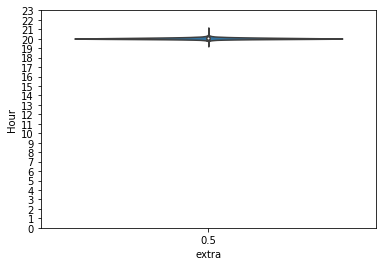

In [137]:
outlier = df[(df.extra == 0.5) & (df.overnight == False)]
sns.violinplot(x=outlier.extra,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(1440,step=60),np.arange(24,step=1))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time']].describe()

There are 14k values wrongfully having a .5 extra cost.
The values range mostly from 19-20, however none was after 20 and so none should have the 0.5 extra cost. The same is true for the bottom, some are right after 6 (Pickup time!), in which case there shouldnt be any tax.

Check the opposite: Values which should have a 0.5 extra, but dont!

,time,pickup_time,dropoff_time
count,11217,11217,11217
mean,0 days 10:18:31.961754,0 days 10:18:06.623428,0 days 10:17:32.571543
std,0 days 07:15:10.431318,0 days 07:15:26.615844,0 days 07:14:31.879177
min,0 days 00:00:28,0 days 00:00:01,0 days 00:00:00
25%,0 days 05:54:35.500000,0 days 05:51:08,0 days 05:57:14
50%,0 days 06:01:17,0 days 05:57:51,0 days 06:04:49
75%,0 days 20:06:13.500000,0 days 20:01:08,0 days 20:09:54
max,0 days 23:59:49.500000,0 days 23:59:54,0 days 23:59:40


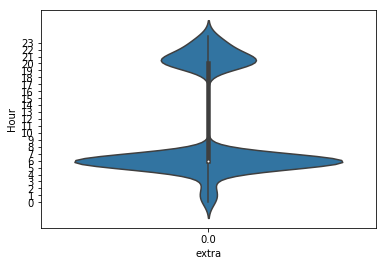

In [138]:
outlier = df[(df.RatecodeID == 1) & (df.extra != 0.5) & (df.overnight == True)]
sns.violinplot(x=outlier.extra,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(1440,step=60),np.arange(24,step=1))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time']].describe()

Most values started before 20, for half the values the mean time is also below 50%, maybe the tax wasn't added then. However, there are many values which cant be correct

In [139]:
outlier.day.value_counts()

Saturday     2148
Thursday     1744
Sunday       1685
Wednesday    1604
Friday       1462
Monday       1338
Tuesday      1236
Name: day, dtype: int64

Check for overnight extra charge!
First check all with extra 1 and outside of an rush hour!

,time,pickup_time,dropoff_time
count,11257,11257,11257
mean,0 days 16:04:14.322776,0 days 15:55:03.145420,0 days 16:13:25.500133
std,0 days 00:06:52.384718,0 days 00:06:07.547375,0 days 00:11:58.520237
min,0 days 15:12:39,0 days 14:24:17,0 days 16:00:00
25%,0 days 16:00:10,0 days 15:53:38,0 days 16:04:48
50%,0 days 16:03:09,0 days 15:56:58,0 days 16:10:14
75%,0 days 16:07:18.500000,0 days 15:58:46,0 days 16:18:20
max,0 days 16:56:26.500000,0 days 15:59:59,0 days 17:59:17


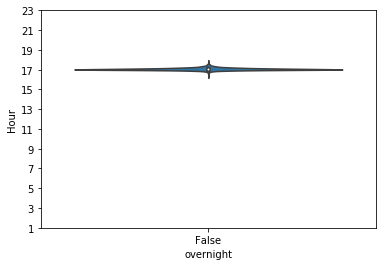

In [142]:
outlier = df[(df.extra ==1) & (df.rush_hour == False) & (df.RatecodeID.isin([1,3,4,5]))]
sns.violinplot(x=outlier.overnight,y=outlier.time.astype('timedelta64[m]'))
plt.yticks(np.arange(0,1440,step=120),np.arange(1,24,step=2))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time']].describe()

,time,pickup_time,dropoff_time
count,21419,21419,21419
mean,0 days 19:03:24.925019,0 days 18:56:11.746953,0 days 19:10:38.103086
std,0 days 01:36:49.131409,0 days 01:37:05.037459,0 days 01:36:48.135619
min,0 days 16:00:36.500000,0 days 16:00:00,0 days 16:01:03
25%,0 days 17:49:45,0 days 17:40:22.500000,0 days 17:58:39
50%,0 days 20:00:13.500000,0 days 19:54:46,0 days 20:04:32
75%,0 days 20:03:54,0 days 19:58:11,0 days 20:10:49
max,0 days 20:44:55.500000,0 days 19:59:59,0 days 21:45:19


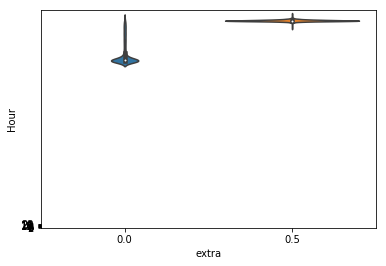

In [180]:
outlier = df[(df.extra != 1) & (df.rush_hour == True) & (df.RatecodeID.isin([1,3,4,5]))]
sns.violinplot(x=outlier.extra,y=outlier.time.astype('timedelta64[ns]'))
plt.yticks(np.arange(0,1440,step=120),np.arange(0,24,step=2))
plt.ylabel('Hour')
outlier[['time','pickup_time','dropoff_time','rush_hour']].describe()

# Train model to predict extra more precise

In [455]:
df['workday'] = (df.tpep_pickup_datetime.dt.weekday < 5)&(df.holiday==False)
df['pickup_time_s'] = df['dropoff_time'].astype('timedelta64[s]')
df['duration_s'] = df['duration'].astype('timedelta64[s]')
df['dropoff_time_s'] = df['pickup_time'].astype('timedelta64[s]')
df['weekday'] = df.tpep_pickup_datetime.dt.weekday

In [500]:
df[df.workday==True].day.value_counts()

Thursday     1566260
Wednesday    1517177
Friday       1282174
Tuesday      1184979
Monday       1129632
Sunday             0
Saturday           0
Name: day, dtype: int64

In [501]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
sample = df.sample(100000)

le.fit(sample.extra)
extra_coded = le.transform(sample.extra)

In [502]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(sample[['pickup_time_s','dropoff_time_s','workday']]\
                                                     ,extra_coded, test_size=0.2, random_state=1337)

In [503]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(random_state=1337)

rfr.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

In [504]:
rfr_pred = rfr.predict(X_test)

In [505]:
# Decode
rfr_pred = le.inverse_transform(rfr_pred)
y_test = le.inverse_transform(y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [506]:
err = pd.DataFrame(y_test-rfr_pred)
err.describe()

,0
count,20000.000000
mean,0.000925
std,0.136336
min,-4.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.500000


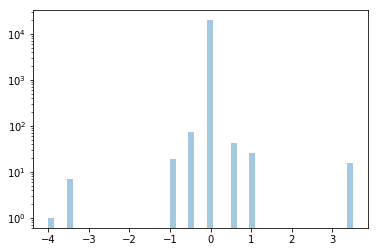

In [507]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [508]:
# Feature importance# Feature 
pd.DataFrame({"Features" : X_train.columns,"estimatedCoefficients": rfr.feature_importances_})

,Features,estimatedCoefficients
0,pickup_time_s,0.524014
1,dropoff_time_s,0.430339
2,workday,0.045646


In [509]:
rfr_pred

array([0. , 0.5, 1. , ..., 0. , 0.5, 1. ])

In [510]:
mean_squared_error(rfr_pred,y_test)

0.0185875

In [511]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9078486 entries, 0 to 11135469
Data columns (total 33 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               category
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
total_amount             float64
duration                 timedelta64[ns]
day                      category
holiday                  bool
overnight                bool
rush_hour                bool
meanDate                 datetime64[ns]
time                     timedelta64[ns]
pickup_time              timedelta64[ns]
dropoff_time             timedelta64[ns]
workday            

# Predict tips amount

In [371]:
# Load packages
from pygeocoder import Geocoder
import pandas as pd
import numpy as np
import reverse_geocoder as rg


In [406]:
# Payment type 2 doesnt have tips
#df['totalWithoutTip'] = df.total_amount-df.tip_amount
sample = df[df.payment_type!=2].sample(10000)

In [396]:
pickup_coord = list(zip(df.pickup_latitude, df.pickup_longitude))
dropoff_coord = list(zip(df.dropoff_latitude, df.dropoff_longitude))

In [404]:
pickup_results = rg.search(pickup_coord) # default mode = 2
dropoff_results = rg.search(dropoff_coord)
df['pickup_area'] = pd.Categorical([d['name'] for d in pickup_results])
df['dropoff_area'] = pd.Categorical([d['name'] for d in dropoff_results])

In [411]:
import sklearn.preprocessing

In [419]:
lb = preprocessing.LabelBinarizer()
lb.fit(sample.pickup_area)
lb.transform(sample.pickup_area)
lb.transform(sample.dropoff_area)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [407]:
df.pickup_area.head()

0        Manhattan
1    New York City
3        Manhattan
4    New York City
5    New York City
Name: pickup_area, dtype: category
Categories (274, object): [Albion, Algona, Allendale, Alpine, ..., Wyandanch, Yellowknife, Yonkers, Youngstown]

In [420]:
X_train, X_test, y_train, y_test \
    = train_test_split(sample[['pickup_time_s','dropoff_time_s','weekday','RatecodeID','totalWithoutTip',\
                               'duration_s','trip_distance','pickup_area','dropoff_area']]\
                     ,sample['tip_amount'], test_size=0.2, random_state=1337)

ValueError: Length of values does not match length of index

In [409]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=1337)

rfr.fit(X_train,y_train)

ValueError: could not convert string to float: 'Long Island City'

In [402]:
rfr_pred = rfr.predict(X_test)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [308]:
err = pd.DataFrame(y_test-rfr_pred)
err.describe()

,tip_amount
count,20000.000000
mean,0.000852
std,1.202008
min,-10.807000
25%,-0.422250
50%,0.076000
75%,0.523000
max,12.030000


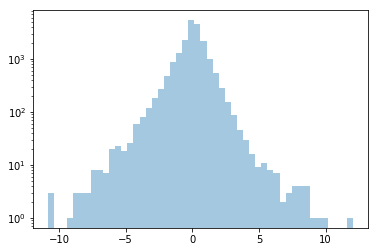

In [309]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [311]:
# Feature importance# Feature 
pd.DataFrame({"Features" : X_train.columns,"estimatedCoefficients": rfr.feature_importances_})

,Features,estimatedCoefficients
0,pickup_time_s,0.058660
1,dropoff_time_s,0.056605
2,weekday,0.027369
3,RatecodeID,0.000994
4,totalWithoutTip,0.692809
5,duration_s,0.089393
6,trip_distance,0.074169


In [310]:
mean_squared_error(rfr_pred,y_test)

1.4447524869000001

# Exploration

Text(0.5,0,'Hour')

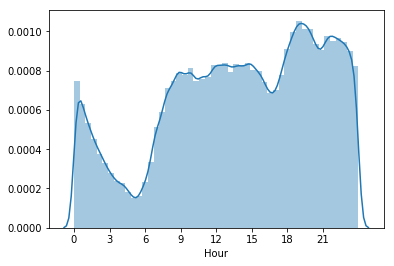

In [26]:
a = sns.distplot(df.time.astype('timedelta64[m]'))
plt.xticks(np.arange(1440,step=180),np.arange(24,step=3))
plt.xlabel('Hour')

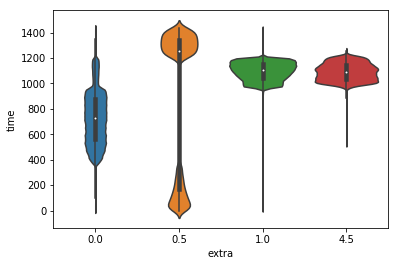

In [27]:
sns.violinplot(x=df.extra,y=df.time.astype('timedelta64[m]'))

In [28]:
df.mta_tax.value_counts t()

SyntaxError: invalid syntax (<ipython-input-28-998877da805c>, line 1)

sns.distplot(df.duration.astype('timedelta64[m]'))

In [ ]:
plt.figure(figsize=(16,9))
plt.subplot(2,3,1)
sns.countplot(df.extra)
plt.subplot(2,3,2)
sns.countplot(df.overnight)
plt.subplot(2,3,3)
sns.countplot(df.rush_hour)
plt.subplot(2,3,4)
sns.countplot(df.day)
plt.subplot(2,3,5)
sns.countplot(df.passenger_count)
plt.subplot(2,3,6)
sns.countplot(df.RatecodeID)

In [ ]:
df["duration_m"] = df.duration.astype('timedelta64[m]')

In [ ]:
sns.lmplot(x="trip_distance", y="duration_m",hue="RatecodeID", data=df.sample(10000))

In [ ]:
df.RatecodeID.value_counts()

# Check Test Data

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.info()

In [ ]:
test.describe()

In [ ]:
test['duration'] = pd.to_datetime(test["tpep_dropoff_datetime"])-pd.to_datetime(test["tpep_pickup_datetime"])

In [ ]:
test[pd.to_datetime(test["tpep_pickup_datetime"]).dt.day != pd.to_datetime(test["tpep_dropoff_datetime"]).dt.day].duration.describe()

In [ ]:
test[test.duration > "2 hours"].RatecodeID.value_counts()

In [ ]:
sns.countplot(test["RatecodeID"])

In [ ]:
sns.countplot(df["extra"])

In [ ]:
sns.countplot(df[df.RatecodeID == 6].extra)

In [ ]:
df[df.mta_tax == 0].RatecodeID.value_counts()

In [ ]:
sns.distplot(df.trip_distance)

In [ ]:
sns.distplot(test.trip_distance)

In [ ]:
sns.distplot(test.duration)

## Notes 

* *improvement_surgcharge* should be constant. Minimum seems to be a sign error. Maximum seems to be a outlier (mistake??)


In [ ]:
df.info()

In [ ]:
df = df.drop(['VendorID','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','Holiday','improvement_surcharge','mta_tax','store_and_fwd_flag','payment_type','duration_m'],axis=1)

In [ ]:
df=df.drop('total',axis=1)

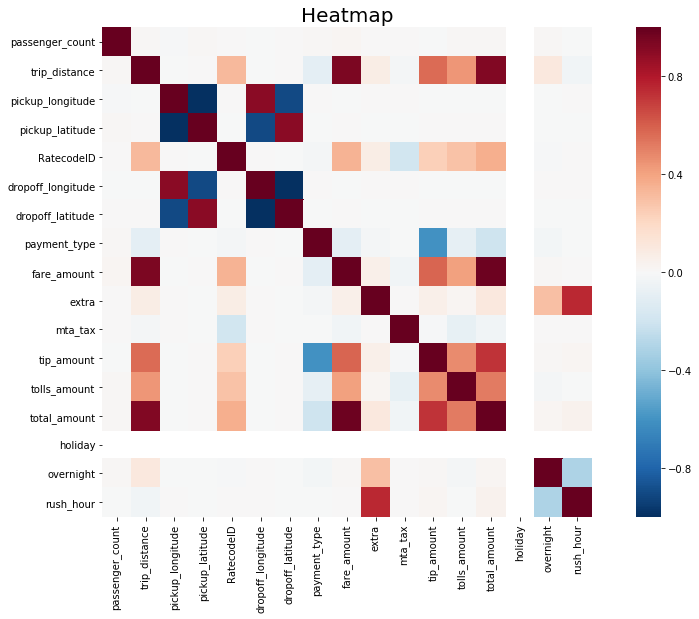

In [147]:
corr = df.drop(['tpep_pickup_datetime','tpep_dropoff_datetime'],axis=1).corr()

plt.figure(figsize=(16,9))

plt.title("Heatmap",fontsize=20)
sns.heatmap(corr, cmap="RdBu_r", square=True)

In [ ]:
sns.distplot(df['total_amount'], hist=True)

In [ ]:
sample = df.sample(10000)

In [ ]:
sns.lmplot(x='extra',y='Overnight',hue='RushHour',data=sample)

In [ ]:
sns.jointplot(x='total_amount',y='fare_amount',data=df, kind='hex')

In [ ]:
sns.lmplot(x='total_amount',y='tip_amount',hue='extra',data=sample)

In [ ]:
sns.lmplot(x='improvement_surcharge',y='mta_tax',data=sample)